In [1]:
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
import random

In [2]:
music_pd=pd.read_csv('full_music_data.csv')
music_pd[['artists_id']]=music_pd[['artists_id']].apply(lambda x: x[0].lstrip("[").rstrip("]") if "," not in x[0] else np.nan,axis=1)
music_pd=music_pd.dropna(how='any').reset_index().drop(['index'],axis=1)

In [3]:
drop_list=['artist_names','release_date','explicit','song_title (censored)']
music_pd=music_pd.drop(drop_list,axis=1)
music_pd

,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,year
0,178301,0.600,0.365,0.131,130.046,-13.083,0,9,0.06720,0.585000,0.0921,0.0498,437200,54,2005
1,178301,0.874,0.326,0.179,119.620,-13.302,0,11,0.01360,0.148000,0.0993,0.1310,581008,53,2005
2,178301,0.670,0.531,0.336,139.385,-8.267,0,9,0.01560,0.345000,0.3060,0.0377,431293,55,2009
3,625201,0.761,0.702,0.850,104.773,-8.523,1,7,0.10800,0.000031,0.0935,0.0389,304427,34,1991
4,625201,0.661,0.828,0.902,115.078,-12.673,0,11,0.27600,0.000001,0.2870,0.0390,264933,37,1987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93925,690254,0.276,0.892,0.715,80.475,-7.035,1,11,0.40900,0.000000,0.7140,0.0893,115973,33,1975
93926,690254,0.700,0.592,0.906,109.847,-10.434,1,11,0.10800,0.018400,0.1180,0.0681,263627,32,1976
93927,690254,0.709,0.709,0.863,111.544,-12.023,1,2,0.11800,0.000011,0.1250,0.0370,158400,31,1987
93928,690254,0.552,0.651,0.533,161.548,-10.624,0,4,0.00494,0.034900,0.1320,0.2290,232533,43,1992


In [4]:
# for col in music_pd.columns:
#     if(col=='artists_id' or col=='year'): continue
#     music_pd[col]=(music_pd[col]-music_pd[col].mean())/(music_pd[col].max()-music_pd[col].min())
# music_pd

In [5]:
influence_pd=pd.read_csv('influence_data.csv')
influence_pd1=influence_pd[['influencer_id','influencer_main_genre']]
influence_pd1.columns=['artists_id','genre']
influence_pd2=influence_pd[['follower_id','follower_main_genre']]
influence_pd2.columns=['artists_id','genre']
influence_pd1=pd.concat([influence_pd1,influence_pd2],axis=0)
influence_pd1=influence_pd1.groupby('artists_id').agg({
    'genre':'first'
})
influence_pd1=influence_pd1.reset_index()
influence_pd1[['artists_id']]=influence_pd1[['artists_id']].astype(np.int64)

In [6]:
music_pd[['artists_id']]=music_pd[['artists_id']].astype(np.int64)
music_pd=pd.merge(music_pd,influence_pd1,on='artists_id',how='left')
music_pd=music_pd.dropna(how='any')
music_pd=music_pd.reset_index().drop(['index','artists_id'],axis=1)

In [7]:
cnt=music_pd.groupby('genre').size()
cnt=cnt.to_dict()
cnt=sorted(cnt.items(),key=lambda x:x[1],reverse=True)
cnt

[('Pop/Rock', 46454),
 ('R&B;', 9839),
 ('Country', 7097),
 ('Jazz', 6055),
 ('Vocal', 5978),
 ('Latin', 4348),
 ('Classical', 2206),
 ('Folk', 1383),
 ('International', 1359),
 ('Reggae', 1345),
 ('Electronic', 1196),
 ('Blues', 1179),
 ('Stage & Screen', 939),
 ('Easy Listening', 796),
 ('Religious', 682),
 ('Comedy/Spoken', 321),
 ('New Age', 267),
 ('Avant-Garde', 221),
 ("Children's", 53),
 ('Unknown', 13)]

In [8]:
genre_to_num={}
num_to_genre={}
music_year={}
maxyear,minyear=2020,1921
per=5
maxbl=(maxyear-minyear)//per
for i in range(len(music_pd)):
    cur=music_pd.loc[i]
    if(genre_to_num.setdefault(cur.genre)==None):
        genre_to_num[cur.genre]=len(genre_to_num)
        num_to_genre[genre_to_num[cur.genre]]=cur.genre
        music_year[cur.genre]={}
    bl=(int(cur.year)-minyear)//per
    if(music_year[cur.genre].setdefault(bl)==None):
        music_year[cur.genre][bl]=cur.drop(['year','genre']).to_dict()
        music_year[cur.genre][bl]['cnt']=1
    else:
        music_year[cur.genre][bl]['cnt']+=1
        for key,val in cur.drop(['year','genre']).to_dict().items():
            music_year[cur.genre][bl][key]+=val

In [9]:
for k,dic in music_year.items():
    for key,val in dic.items():
        for fk,fv in val.items():
            if(fk=='cnt'): continue
            else:
                music_year[k][key][fk]/=music_year[k][key]['cnt']

In [10]:
music_year[cnt[0][0]]

{12: {'danceability': 0.5173617191870212,
  'energy': 0.6914406658586583,
  'valence': 0.5643790788737647,
  'tempo': 125.79019746410543,
  'loudness': -9.954040835353346,
  'mode': 0.700727204922618,
  'key': 5.2616073093417866,
  'acousticness': 0.17857334063024513,
  'instrumentalness': 0.11396576603953039,
  'liveness': 0.22360290881968994,
  'speechiness': 0.05885774752936797,
  'duration_ms': 245408.3056125303,
  'popularity': 36.13276151407794,
  'cnt': 5363},
 15: {'danceability': 0.5086684927450407,
  'energy': 0.7161743382291973,
  'valence': 0.5014044714243404,
  'tempo': 122.01040183594905,
  'loudness': -7.497572105419027,
  'mode': 0.7281610897246077,
  'key': 5.260882440035535,
  'acousticness': 0.1723772061830024,
  'instrumentalness': 0.09779481599052409,
  'liveness': 0.21908309150133257,
  'speechiness': 0.06517379330766958,
  'duration_ms': 246373.56114894876,
  'popularity': 46.20432336393248,
  'cnt': 3377},
 13: {'danceability': 0.5001412262156457,
  'energy': 0.

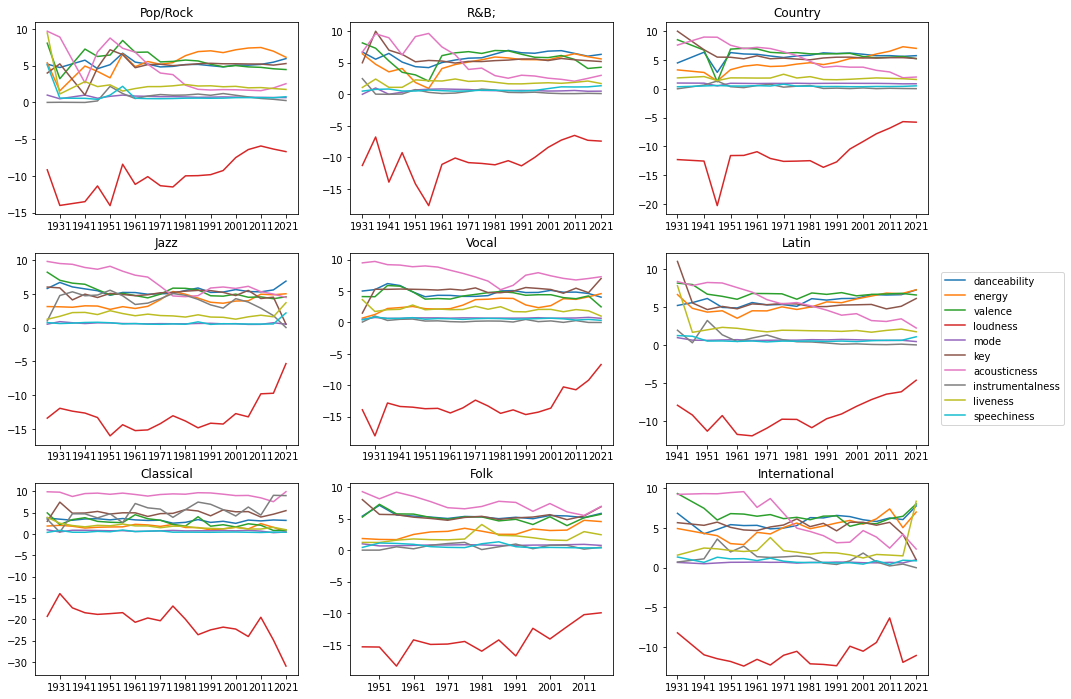

In [17]:
label=[]
def draw(data,pos):
    plt.subplot(pos)
    data=sorted(data.items(),key=lambda x:x[0])
    y=[]
    x=[]
    for key,val in data:
        y.append([])
        x.append(key)
        for tk,tv in val.items():
            if(tk=='popularity' or tk=='duration_ms' or tk=='tempo'):continue
            if(tk=='key' or tk=='loudness' or tk=='mode'): y[len(y)-1].append(tv)
            else: y[len(y)-1].append(tv*10)
#     f=True
#     while f:
#         f=False
#         for i in range(len(y)):
#             if(y[i][len(y[i])-1]<=per*2):
#                 y.pop(i)
#                 x.pop(i)
#                 f=True
#                 break
    y=np.array(y)
    #     print(x)
    #     print(y)
    for i in range(len(x)):
        x[i]=(x[i]+1)*per+minyear
    plt.xticks(range(1921,2025,10))
    if(pos==339):
        for i in range(len(y[0])-1):
            plt.plot(x,y[:,i],label=label[i])
        plt.legend(bbox_to_anchor=(1.05, 2.1), loc='upper left', borderaxespad=0.)
    else:
        for i in range(len(y[0])-1):
            plt.plot(x,y[:,i])
#     print(y)
#     print(x)
for tk in music_year[cnt[0][0]][1].keys():
    if(tk=='popularity' or tk=='duration_ms' or tk=='tempo'):continue
    label.append(tk)
label.append('cnt')
# print(label)
cur=1
plt.figure(figsize=(16,12))
for i in range(9):
    draw(music_year[cnt[i][0]],int("33"+str(i+1)))
    plt.title(label=cnt[i][0])
    cur+=1
plt.savefig("折线图1.jpg")
#     break

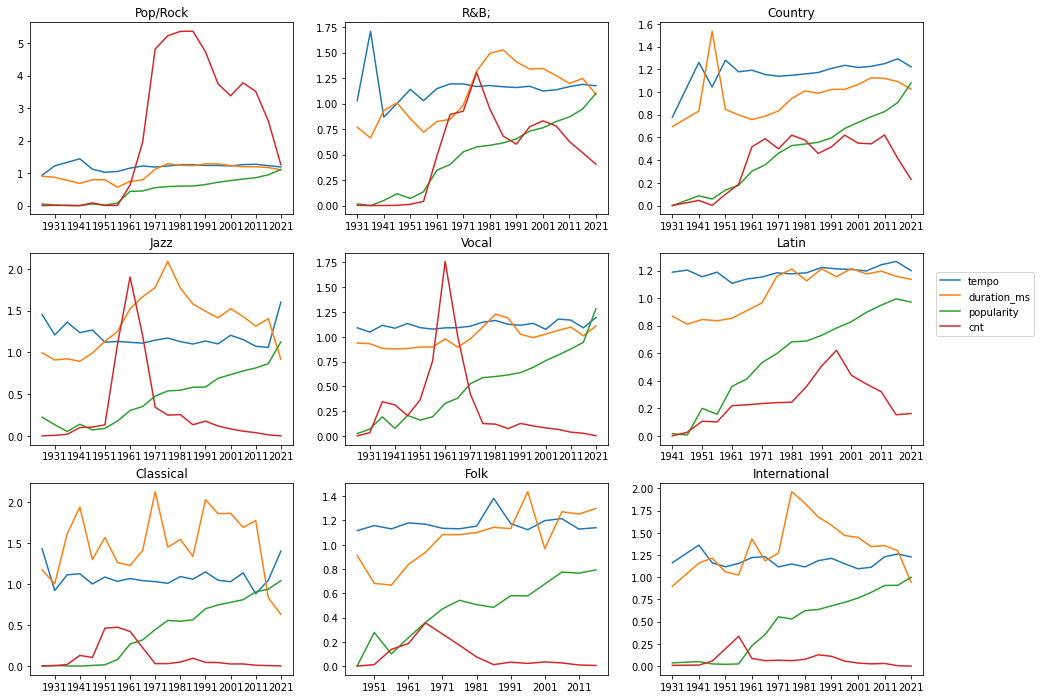

In [18]:
def draw2(data,pos):
    plt.subplot(pos)
    data=sorted(data.items(),key=lambda x:x[0])
    y=[]
    x=[]
    for key,val in data:
        y.append([])
        x.append(key)
        for tk,tv in val.items():
            if(tk=='popularity'):
                y[len(y)-1].append(tv/60)
            elif(tk=='tempo'):
                y[len(y)-1].append(tv/100)
            elif(tk=='duration_ms'):
                y[len(y)-1].append(tv/200000)
            elif(tk=='cnt'):
                y[len(y)-1].append(tv/1000)
#     f=True
#     while f:
#         f=False
#         for i in range(len(y)):
#             if(y[i][len(y[i])-1]<=per*2/10000):
#                 y.pop(i)
#                 x.pop(i)
#                 f=True
#                 break
    y=np.array(y)
    #     print(x)
    #     print(y)
    for i in range(len(x)):
        x[i]=(x[i]+1)*per+minyear
    plt.xticks(range(1921,2025,10))
    if(pos==339):
        for i in range(len(y[0])):
            plt.plot(x,y[:,i],label=label[i])
        plt.legend(bbox_to_anchor=(1.05, 2.1), loc='upper left', borderaxespad=0.)
    else:
        for i in range(len(y[0])):
            plt.plot(x,y[:,i])
            
plt.figure(figsize=(16,12))
label=[]
for tk in music_year[cnt[0][0]][1].keys():
    if(tk=='popularity' or tk=='duration_ms' or tk=='tempo' or tk=='cnt'):
        label.append(tk)
# label.append('cnt')
for i in range(9):
    draw2(music_year[cnt[i][0]],int("33"+str(i+1)))
    plt.title(label=cnt[i][0])
plt.savefig("折线图2.jpg")

In [13]:
y=[[1,2],[3,4]]
y=np.array(y)
print(y[:,0])

[1 3]


In [14]:
year={}
for i in range(maxbl+1):
    year[i]=[0 for i in range(len(music_year))]
idx=0
head_title=[]
for i in range(9):
    v=music_year[cnt[i][0]]
#     print(v)
    v=sorted(v.items(),key=lambda x:x[0])
    for key,val in v:
        year[key][idx]+=val['popularity']
    idx+=1
#     break


In [15]:
print(year)

{0: [3.0, 0, 0, 13.5, 1.5, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1: [1.0, 1.0, 0.0, 8.125, 4.176470588235294, 0, 0.5, 0, 2.2222222222222223, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2: [0, 0.0, 0, 3.238095238095238, 11.621387283236995, 0, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 3: [0.0, 3.0, 5.173913043478261, 8.485148514851485, 4.592356687898089, 1.0, 0.007692307692307693, 0, 3.0833333333333335, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 4: [3.072289156626506, 7.0, 3.5, 4.336448598130841, 12.490291262135923, 0.4444444444444444, 0.45714285714285713, 0.3333333333333333, 1.5263157894736843, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 5: [0.8333333333333334, 4.230769230769231, 8.191919191919192, 5.507462686567164, 9.650137741046832, 12.037383177570094, 0.9567099567099567, 16.733333333333334, 1.2564102564102564, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 6: [4.875, 8.146341463414634, 10.76063829787234, 10.758652094717668, 11.652575957727873, 9.470588235294118, 4.843881856540085, 6.185714285714286, 1.52225519

In [16]:
head_title=[cnt[i][0] for i in range(9)]
head="year"
for i in range(len(head_title)):
    head+=','+head_title[i]
with open('q3_popularity.txt','w+',encoding='utf-8') as f:
    f.write(head+"\n")
    for key,val in year.items():
        ans=str(minyear+(key+1)*per)
        for v in val:
            ans+=","+str(v)
        f.write(ans+"\n")

In [25]:
with open('music_per_year2.csv','w+',encoding='utf-8') as f:
    f.write('year,genre')
    for col in music_year[cnt[i][0]][1].keys():
        f.write(","+col)
    f.write("\n")
    for i in range(9):
        v=music_year[cnt[i][0]]
        v=sorted(v.items(),key=lambda x:x[0])
        for key,vv in v:
            ans=str(minyear+(key+1)*per)+","+cnt[i][0]
            for val in vv.values():
                ans+=','+str(val)
            f.write(ans+"\n")

In [19]:
# music_year

{'Electronic': {16: {'danceability': 0.5998938356164385,
   'energy': 0.6680033013698633,
   'valence': 0.4704486301369861,
   'tempo': 119.5112945205479,
   'loudness': -9.289965753424656,
   'mode': 0.5958904109589042,
   'key': 5.691780821917808,
   'acousticness': 0.189283042739726,
   'instrumentalness': 0.40686552616438354,
   'liveness': 0.21215410958904105,
   'speechiness': 0.0700678082191781,
   'duration_ms': 275552.44520547945,
   'popularity': 50.63013698630137,
   'cnt': 146},
  17: {'danceability': 0.6030299435028245,
   'energy': 0.674816384180791,
   'valence': 0.44059604519774037,
   'tempo': 120.24877401129937,
   'loudness': -8.378689265536721,
   'mode': 0.5141242937853108,
   'key': 5.423728813559322,
   'acousticness': 0.1607905768361582,
   'instrumentalness': 0.35745840180790966,
   'liveness': 0.21254180790960456,
   'speechiness': 0.0823322033898305,
   'duration_ms': 265442.5084745763,
   'popularity': 50.440677966101696,
   'cnt': 177},
  14: {'danceability